In [1]:
import numpy as np 
import pandas as pd 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")
from datetime import datetime
import warnings

warnings.filterwarnings("ignore")
save_path = r"C:\Users\86187\Desktop\CUHKSZ\FTE4560\Project\Project2\存档\普通数据3"
model_name = ["LSTM", "ICA_LSTM", "CEEMDAN_LSTM", "CEEMDAN_LSTM_ALL", "CEEMDAN_ICA_LSTM"]
mod_train_loss = []
mod_test_loss = []

In [2]:
# import tushare as ts
# ts.set_token("3184283408ad311b8d975801059abf501c08c132f9bde78b44396b1b")

# code='sh'
# pro = ts.pro_api()
# df = pro.index_daily(ts_code=code, start_date="20100101", end_date="20201231")

In [3]:
# b = b.sort_index()
# b

In [4]:
from data_generator import *
from rnn import *
from optimizers import *
from activator import *
from utils import *
from Structure import *
from fclayer import *
from LSTM import *
from ICA import *

In [5]:
SZ_index = pd.read_csv(r"C:\Users\86187\Desktop\CUHKSZ\FTE4560\CODES\SequentialNeuralNet\IDX_Idxtrd.csv")
SZ_index = SZ_index.drop("Indexcd", axis=1)
SZ_index.columns = ["Date", "Open", "High", "Low", "Close", "Amount", "Volume"]
SZ_index = SZ_index.set_index("Date")
SZ_index.index = pd.to_datetime(SZ_index.index)
SZ_index

,Open,High,Low,Close,Amount,Volume
Date,,,,,,
2016-04-21,2954.370,2990.673,2943.464,2952.891,1894068.49,20647712.69
2016-04-22,2933.035,2960.209,2926.776,2959.240,1372116.68,14880043.08
2016-04-25,2949.973,2954.092,2917.020,2946.670,1258562.43,14063875.63
2016-04-26,2944.716,2965.429,2933.971,2964.700,1177116.04,13429245.87
2016-04-27,2967.190,2976.022,2949.432,2953.671,1308676.40,15028630.15
...,...,...,...,...,...,...
2021-04-14,3397.021,3420.028,3392.975,3416.721,2332423.27,26901007.06
2021-04-15,3409.614,3409.614,3373.094,3398.988,2340050.54,27256919.68
2021-04-16,3407.188,3432.629,3394.134,3426.618,2585796.72,29595109.47


In [6]:
def process_data(data, look_back, forward_days, jump=1):
    X,Y = [], []
    for i in range(0, len(data)-look_back-forward_days+1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

# look_back = 20
# forward_days = 5


# X_test, Y_test = process_data(test_data, look_back, forward_days, forward_days)
# Y_test = Y_test.reshape(len(Y_test), -1)


# X,y = process_data(train_data, look_back, forward_days)
# # X_train, X_validate, Y_train, Y_validate = train_test_split(X,y, test_size=0.3, random_state=2)
# X_train, Y_train = X[:int(len(X)*0.7)], y[:int(len(y)*0.7)]
# X_validate, Y_validate = X[int(len(X)*0.7):], y[int(len(y)*0.7):]
# Y_train = Y_train.reshape(len(Y_train), -1)
# Y_validate = Y_validate.reshape(len(Y_validate), -1)


# print(f"The shape of X_train is {X_train.shape}")
# print(f"The shape of Y_train is {Y_train.shape}")
# print(f"The shape of X_validate is {X_validate.shape}")
# print(f"The shape of Y_validate is {Y_validate.shape}")
# print(f"The shape of X_test is {X_test.shape}")
# print(f"The shape of Y_test is {Y_test.shape}")

In [7]:
BATCH_SIZE = 10
NUM_NEURONS_FirstLayer = 20
NUM_NEURONS_SecondLayer = 60
optmParamsLSTM = (0.9, 0.999, 1e-8)
optmParamsFC = (0.9, 0.999, 1e-8)


EPOCH_NUM = 100
lrt1 = 0.01
lrt2 = 0.05
lrt = lrt1
train_loss = []
val_loss = []
last_loss = -1

look_back = 20
forward_days = 5

# CEEMDAN and LSTM

## Using only price series

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data_ceemd_ = SZ_index[["Close"]]
# scl = MinMaxScaler()
# data_ica_ = scl.fit_transform(data_)
# data_ceemd_ = data_ceemd_.applymap(lambda x: np.log(x))
# data_ceemd_ = data_ceemd_.diff(axis=0)
data_ceemd_.dropna(inplace=True)
scl = MinMaxScaler()
data_ceemd_ = scl.fit_transform(data_ceemd_)
data_ceemd = pd.DataFrame(data=data_ceemd_, index=SZ_index.index)
data_ceemd.shape

(1216, 1)

<AxesSubplot:ylabel='Count'>

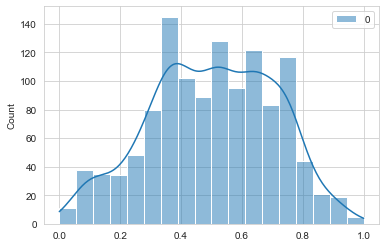

In [9]:
sns.histplot(data_ceemd, kde=True)
# plt.savefig(save_path+r"\price_histplot.png")

In [2]:
from PyEMD import CEEMDAN

ceemdan = CEEMDAN()
cIMFs = ceemdan(np.ravel(np.array(data_ceemd)))
cIMFs = cIMFs.T

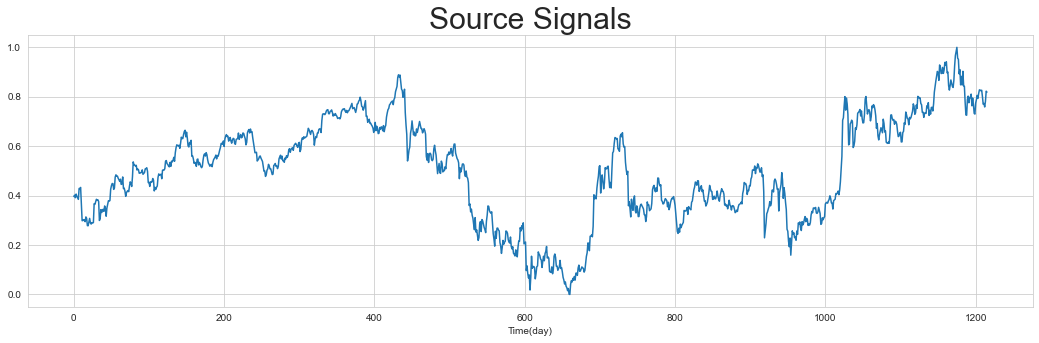

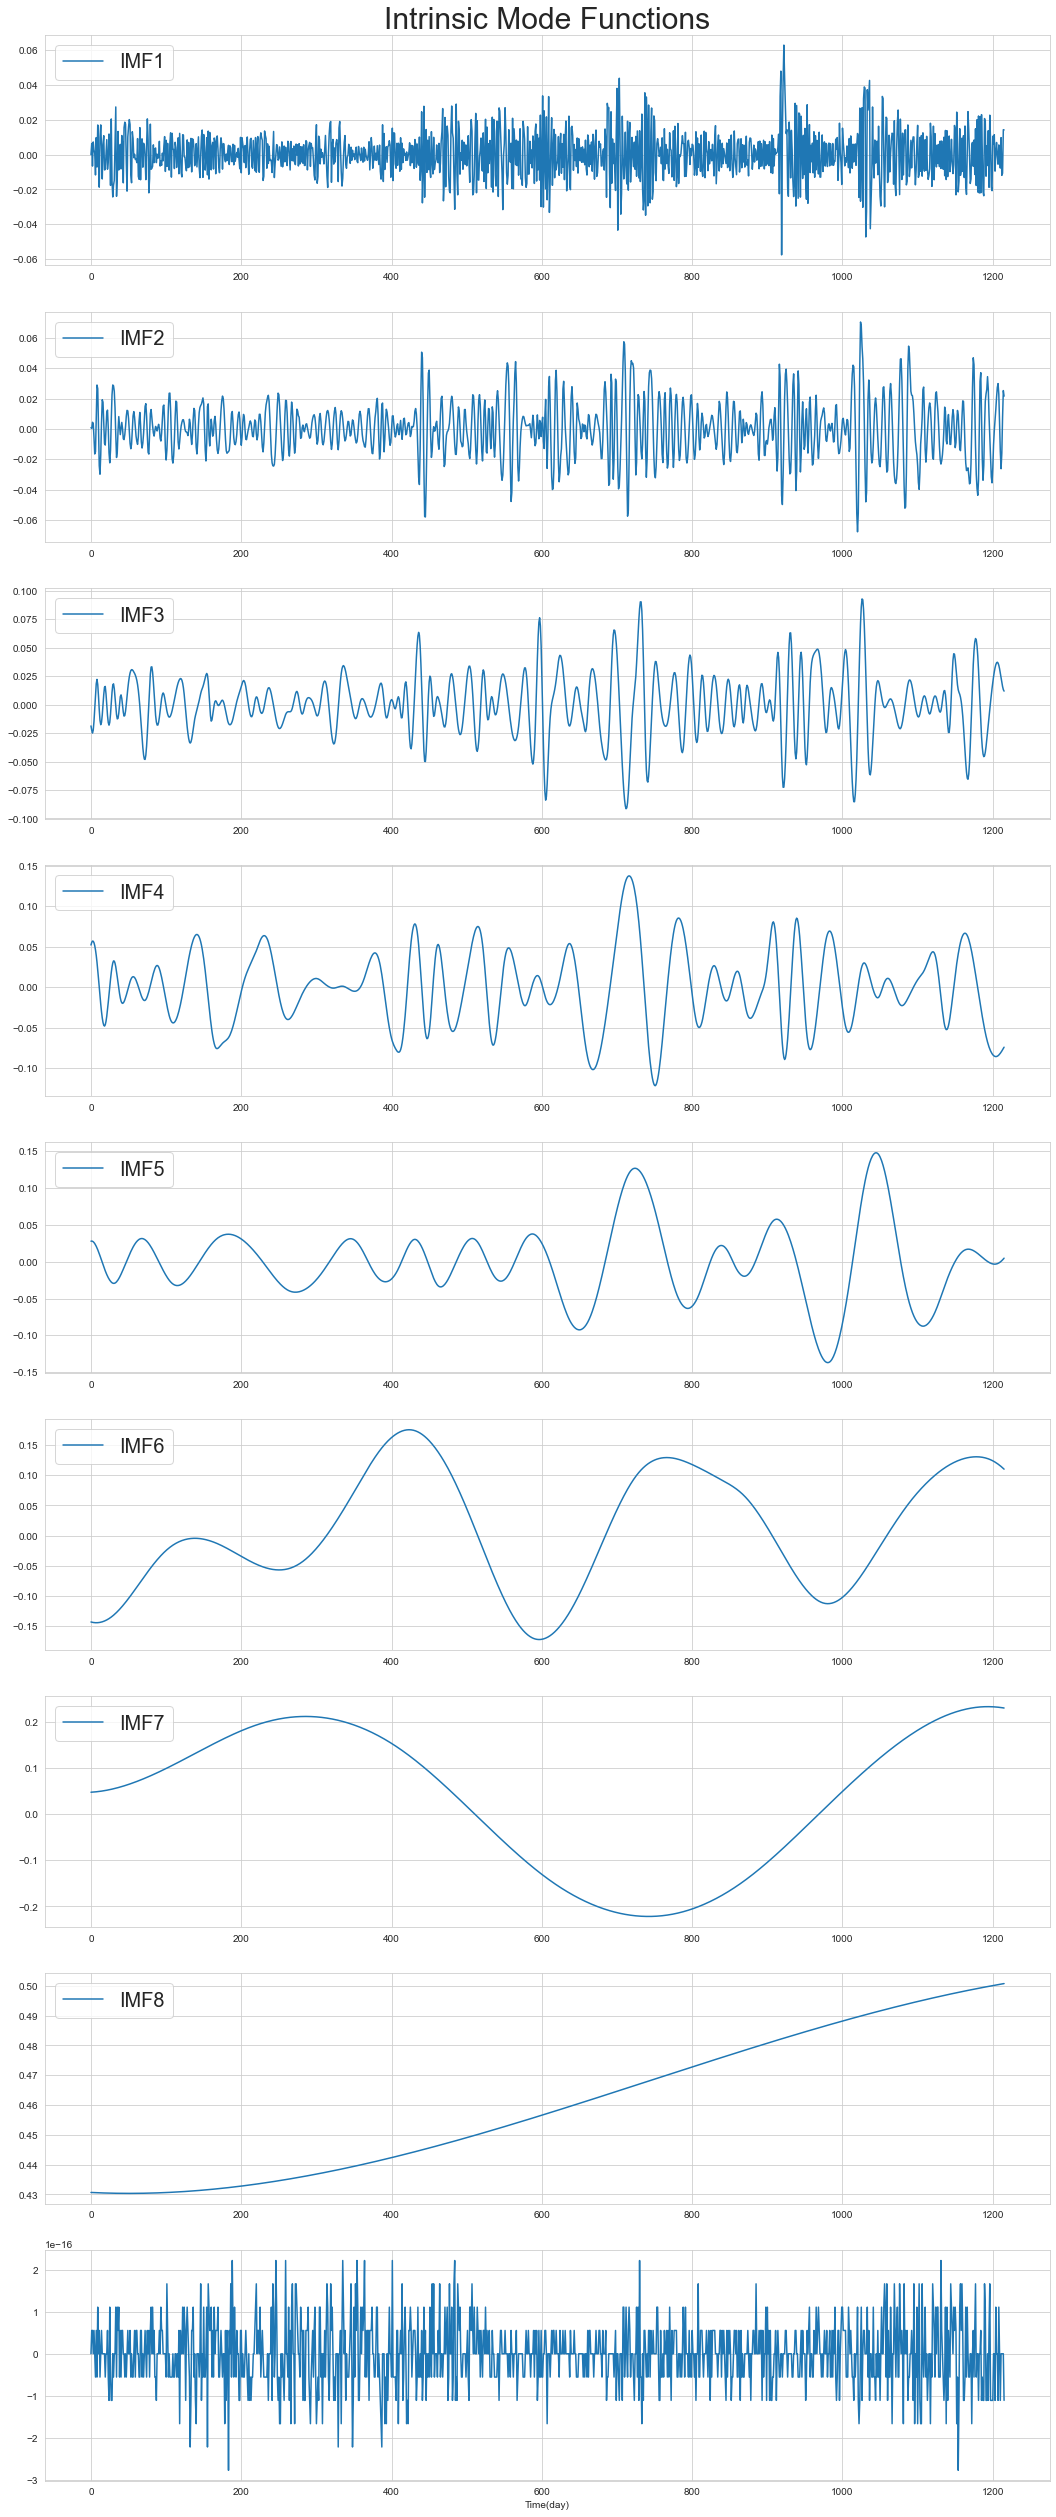

In [11]:
fig,ax = plt.subplots(1,1,figsize=(18,5))
ax.plot(np.array(data_ceemd))
ax.set_title("Source Signals", fontsize=30)
ax.set_xlabel("Time(day)")
plt.savefig(save_path+r"\CEEMDAN_source.png")

fig,ax = plt.subplots(cIMFs.shape[1]+1,1,figsize=(18,(cIMFs.shape[1]+1)*5))
ax[0].set_title("Intrinsic Mode Functions", fontsize=30)
error = np.ravel(np.array(data_ceemd))
for i in range(cIMFs.shape[1]):
    ax[i].plot(cIMFs[:,i], label="IMF%d"%(i+1))
    ax[i].legend(loc="upper left", fontsize=20)
    error = error - cIMFs[:,i]
ax[i+1].plot(error, label="ERROR")
ax[i+1].set_xlabel("Time(day)")
plt.savefig(save_path+r"\CEEMDAN_IMF.png")

In [12]:
# dataset = np.concatenate((cIMFs, error.reshape(-1,1)), axis=1)
# dataset.shape

In [13]:
dataset = cIMFs
dataset.shape

(1216, 8)

In [14]:
train_size = 0.8
validation_size = 0.1

train_data = dataset[:int(dataset.shape[0]*train_size), :]
train_price_ = np.array(SZ_index[["Close"]])[:int(dataset.shape[0]*train_size), :]
test_data = dataset[int(dataset.shape[0]*train_size):,:]
test_price_ = np.array(SZ_index[["Close"]])[int(dataset.shape[0]*train_size):,:]


X_test, Y_test = process_data(test_data, look_back, forward_days, forward_days)
# Y_test_price =  process_data(test_price, look_back, forward_days, forward_days)
_, test_price = process_data(test_price_, look_back, forward_days, forward_days)

X_train, Y_train = process_data(train_data[:-int(train_data.shape[0]*validation_size),:], look_back, forward_days, forward_days)
X_validate, Y_validate = process_data(train_data[int(train_data.shape[0]*(1-validation_size)):,:], look_back, forward_days, forward_days)
_, train_price = process_data(train_price_[:-int(train_data.shape[0]*validation_size),:], look_back, forward_days, forward_days)


Y_test = Y_test.reshape(Y_test.shape[0], -1)
Y_train = Y_train.reshape(Y_train.shape[0], -1)
Y_validate = Y_validate.reshape(Y_validate.shape[0], -1)
# train_price = train_price[:-int(train_data.shape[0]*validation_size), :]
train_price = np.ravel(train_price).reshape(-1,1)
test_price = np.ravel(test_price).reshape(-1,1)

print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of Y_train is {Y_train.shape}")
print(f"The shape of X_validate is {X_validate.shape}")
print(f"The shape of Y_validate is {Y_validate.shape}")
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of Y_test is {Y_test.shape}")
print(f"The shape of train_price is {train_price.shape}")
print(f"The shape of test_price is {test_price.shape}")

The shape of X_train is (171, 20, 8)
The shape of Y_train is (171, 40)
The shape of X_validate is (15, 20, 8)
The shape of Y_validate is (15, 40)
The shape of X_test is (44, 20, 8)
The shape of Y_test is (44, 40)
The shape of train_price is (855, 1)
The shape of test_price is (220, 1)


In [15]:
BATCH_SIZE = 10
NUM_NEURONS_FirstLayer = 20
NUM_NEURONS_SecondLayer = 60
optmParamsLSTM = (0.9, 0.999, 1e-8)
optmParamsFC = (0.9, 0.999, 1e-8)

optimizers = AdamOptimizer
lstm_layer1 = LSTMLayer("LSTM1", BATCH_SIZE, NUM_NEURONS_FirstLayer, 1, optimizers, optmParamsLSTM, 0.9, np.float32, 1e-4)
lstm_layer2 = LSTMLayer("LSTM2", BATCH_SIZE, NUM_NEURONS_SecondLayer, 1, optimizers, optmParamsLSTM, 0.99, np.float32, 1e-4)
fc_layer = FCLayer("FC", BATCH_SIZE, NUM_NEURONS_SecondLayer*look_back, Y_train.shape[1], Pass, optimizers, optmParamsFC, True, np.float32, 1e-4)
seqLayers = [lstm_layer1, lstm_layer2, fc_layer]
sess = Session(seqLayers, MSE)
train_loss = []
val_loss = []
last_loss = -1


def iterate_minibatches(input, target, batch_size, shuffle=False):
    assert input.shape[0] == target.shape[0]
    if shuffle:
        indices = np.arange(input.shape[0])
        np.random.shuffle(indices)  
    for start_idx in range(0, input.shape[0]-batch_size+1, batch_size):
        if shuffle:
            output = indices[start_idx:start_idx:batch_size]
        else:
            output = slice(start_idx, start_idx+batch_size)
        yield input[output], target[output]

EPOCH_NUM = 100
lrt1 = 0.01
lrt2 = 0.05
lrt = lrt1

iter = 0
for epoch in range(EPOCH_NUM):
    start = time.time()
    for batch in iterate_minibatches(X_train, Y_train, BATCH_SIZE, False):
        x_batch, y_batch = batch 
        # y_batch = y_batch.reshape(len(y_batch), -1)
        acc_, loss_t = sess.train_steps(x_batch, y_batch, lrt)

    if epoch == 0:
        last_loss = loss_t
    else:
        loss_diff = loss_t - last_loss
        if loss_diff > 0:
            lrt = lrt2
        else:
            lrt = lrt1
        last_loss = loss_t

    _, acc_val, loss_val = sess.validation(X_validate, Y_validate)
    train_loss.append(loss_t)
    val_loss.append(loss_val)
    
    s = time.time() - start
    iter += 1
    print(f"epoch {epoch+1}/{EPOCH_NUM}: train_loss={loss_t:.4f}, train_accuracy={acc_:.4f}, val_loss={loss_val:.4f}, val_accuracy={acc_val:.4f}, time: {s:.3f}, lrt: {lrt}")

epoch 1/100: train_loss=0.0005, train_accuracy=0.0005, val_loss=0.0034, val_accuracy=0.0034, time: 1.259, lrt: 0.01
epoch 2/100: train_loss=0.0030, train_accuracy=0.0030, val_loss=0.0040, val_accuracy=0.0040, time: 0.329, lrt: 0.05
epoch 3/100: train_loss=0.0025, train_accuracy=0.0025, val_loss=0.0090, val_accuracy=0.0090, time: 0.318, lrt: 0.01
epoch 4/100: train_loss=0.0029, train_accuracy=0.0029, val_loss=0.0046, val_accuracy=0.0046, time: 0.318, lrt: 0.05
epoch 5/100: train_loss=0.0021, train_accuracy=0.0021, val_loss=0.0047, val_accuracy=0.0047, time: 0.313, lrt: 0.01
epoch 6/100: train_loss=0.0057, train_accuracy=0.0057, val_loss=0.0029, val_accuracy=0.0029, time: 0.313, lrt: 0.05
epoch 7/100: train_loss=0.0018, train_accuracy=0.0018, val_loss=0.0010, val_accuracy=0.0010, time: 0.346, lrt: 0.01
epoch 8/100: train_loss=0.0014, train_accuracy=0.0014, val_loss=0.0010, val_accuracy=0.0010, time: 0.327, lrt: 0.01
epoch 9/100: train_loss=0.0026, train_accuracy=0.0026, val_loss=0.0013, 

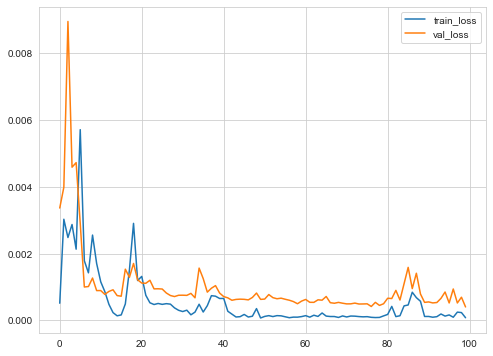

<Figure size 432x288 with 0 Axes>

In [16]:
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(np.arange(len(train_loss)), train_loss, label="train_loss")
ax.plot(np.arange(len(val_loss)), val_loss, label="val_loss")
ax.legend(loc="best")
plt.show()
plt.savefig(save_path+r"\CEEMDAN_loss_all.png")

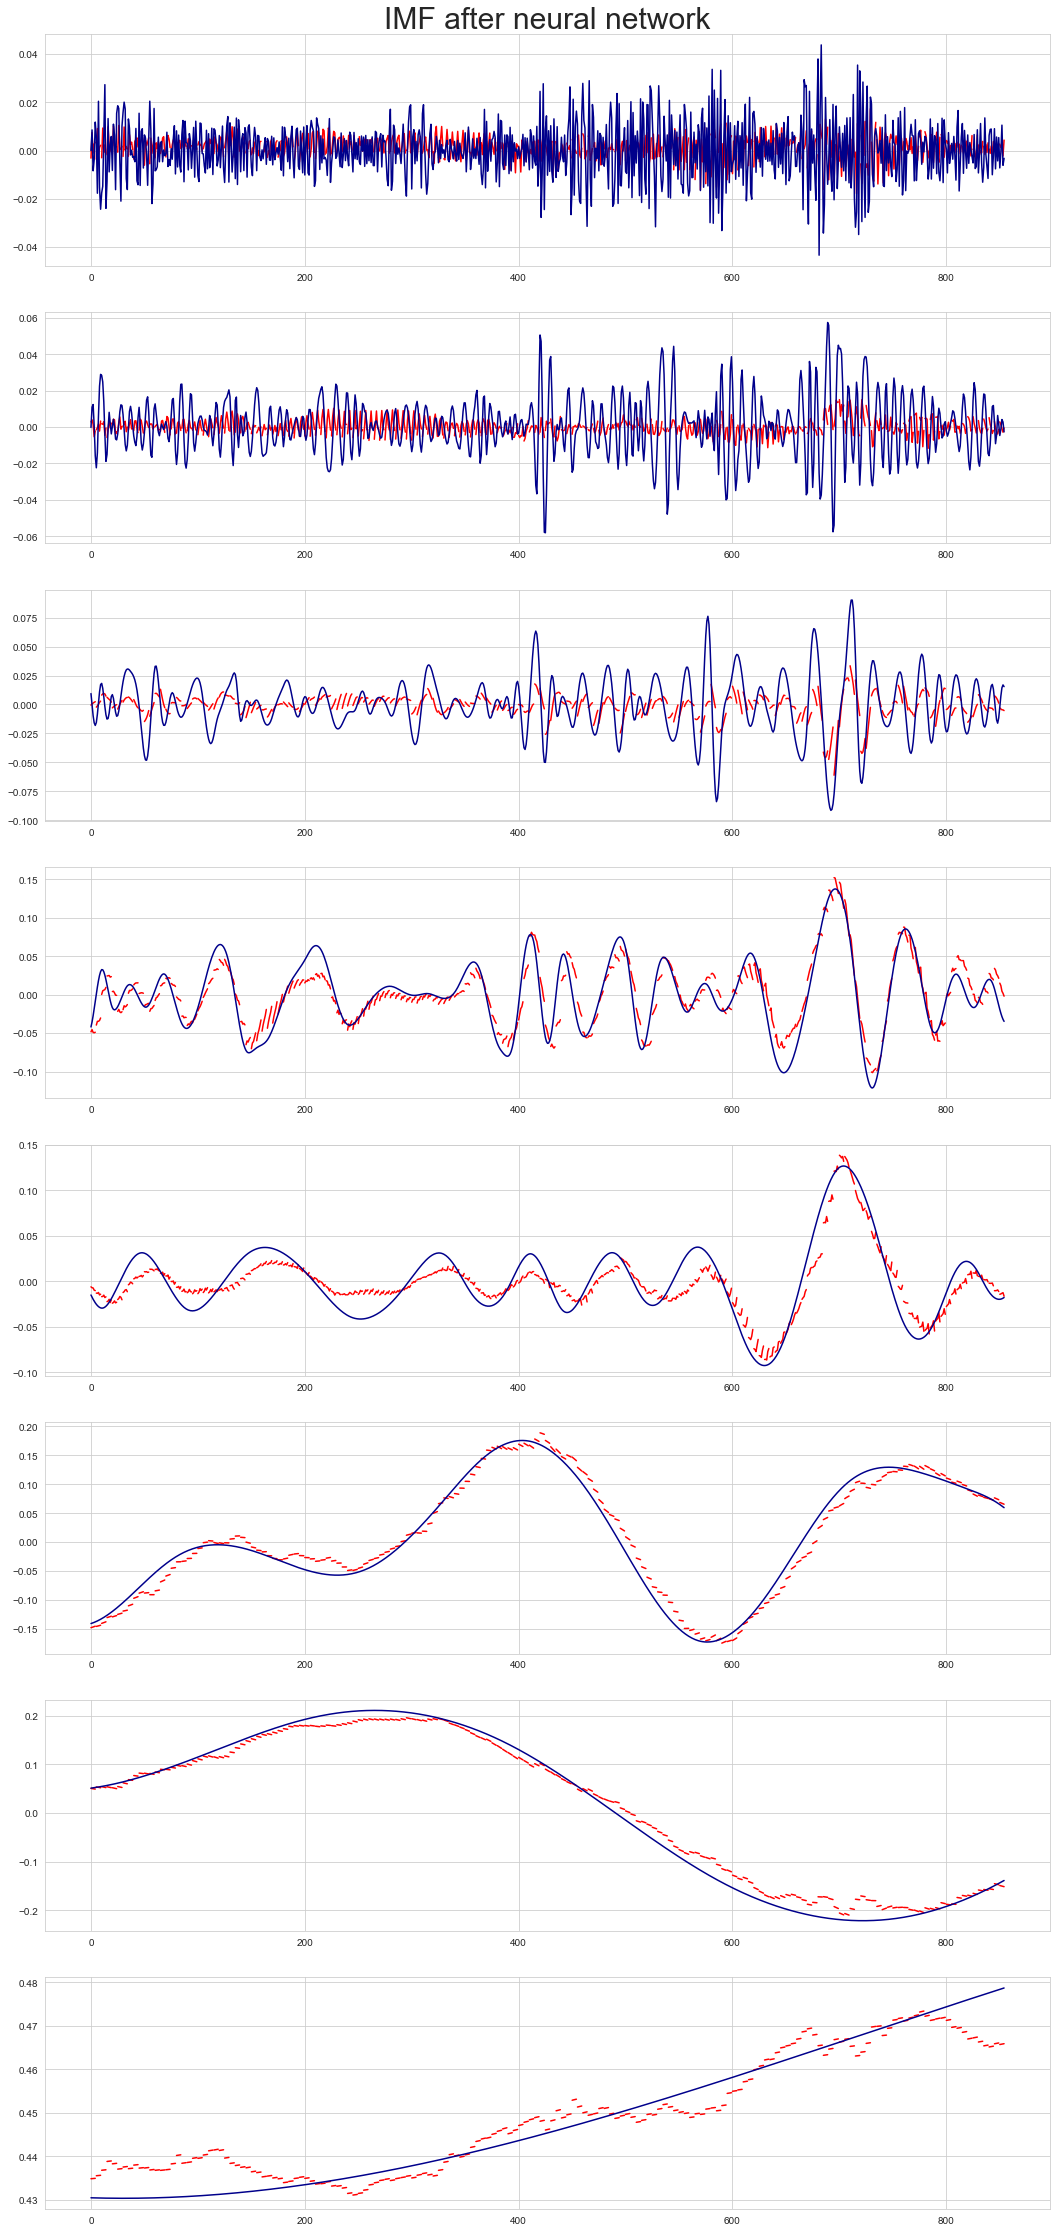

In [17]:
y_hat_train,loss_train,_,_ = sess.inference(X_train, Y_train, val=True)
y_hat_ = np.reshape(y_hat_train, (y_hat_train.shape[0], -1, dataset.shape[1]))
y_train_ = np.reshape(Y_train, (Y_train.shape[0], -1, dataset.shape[1]))

fig,ax = plt.subplots(y_hat_.shape[-1],1,figsize=(18,(y_hat_.shape[-1])*5))
ax[0].set_title("IMF after neural network", fontsize=30)
price_pred = 0
for i in range(y_hat_.shape[-1]):
    temp = y_hat_[:,:,i]
    price_pred += temp.reshape(-1,1)
    for j in range(len(temp)):
        ax[i].plot([x+j*forward_days for x in range(len(temp[j]))], temp[j].reshape(-1,1), color="red")
    ax[i].plot(y_train_[:,:,i].reshape(-1,1), color="darkblue")
price_pred = scl.inverse_transform(price_pred)
plt.show()
# plt.savefig(save_path+r"\CEEMDAN_IMF.png")

In [18]:
train_error = Tools.mse(np.ravel(train_price), np.ravel(price_pred))
train_error

1363.920370235177

In [19]:
np.ravel(train_price).shape

(855,)

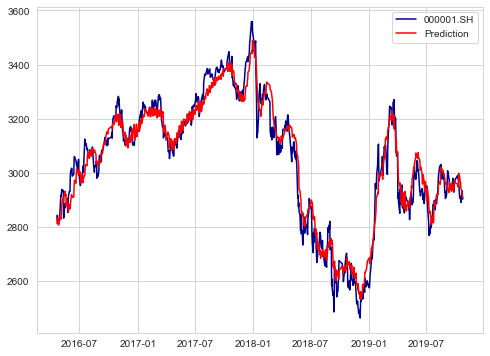

In [20]:
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(pd.to_datetime(SZ_index.index)[:train_price.shape[0]], np.ravel(train_price), color="darkblue", label="000001.SH")
ax.plot(pd.to_datetime(SZ_index.index)[:train_price.shape[0]], np.ravel(price_pred), color="red", label="Prediction")

ax.legend()

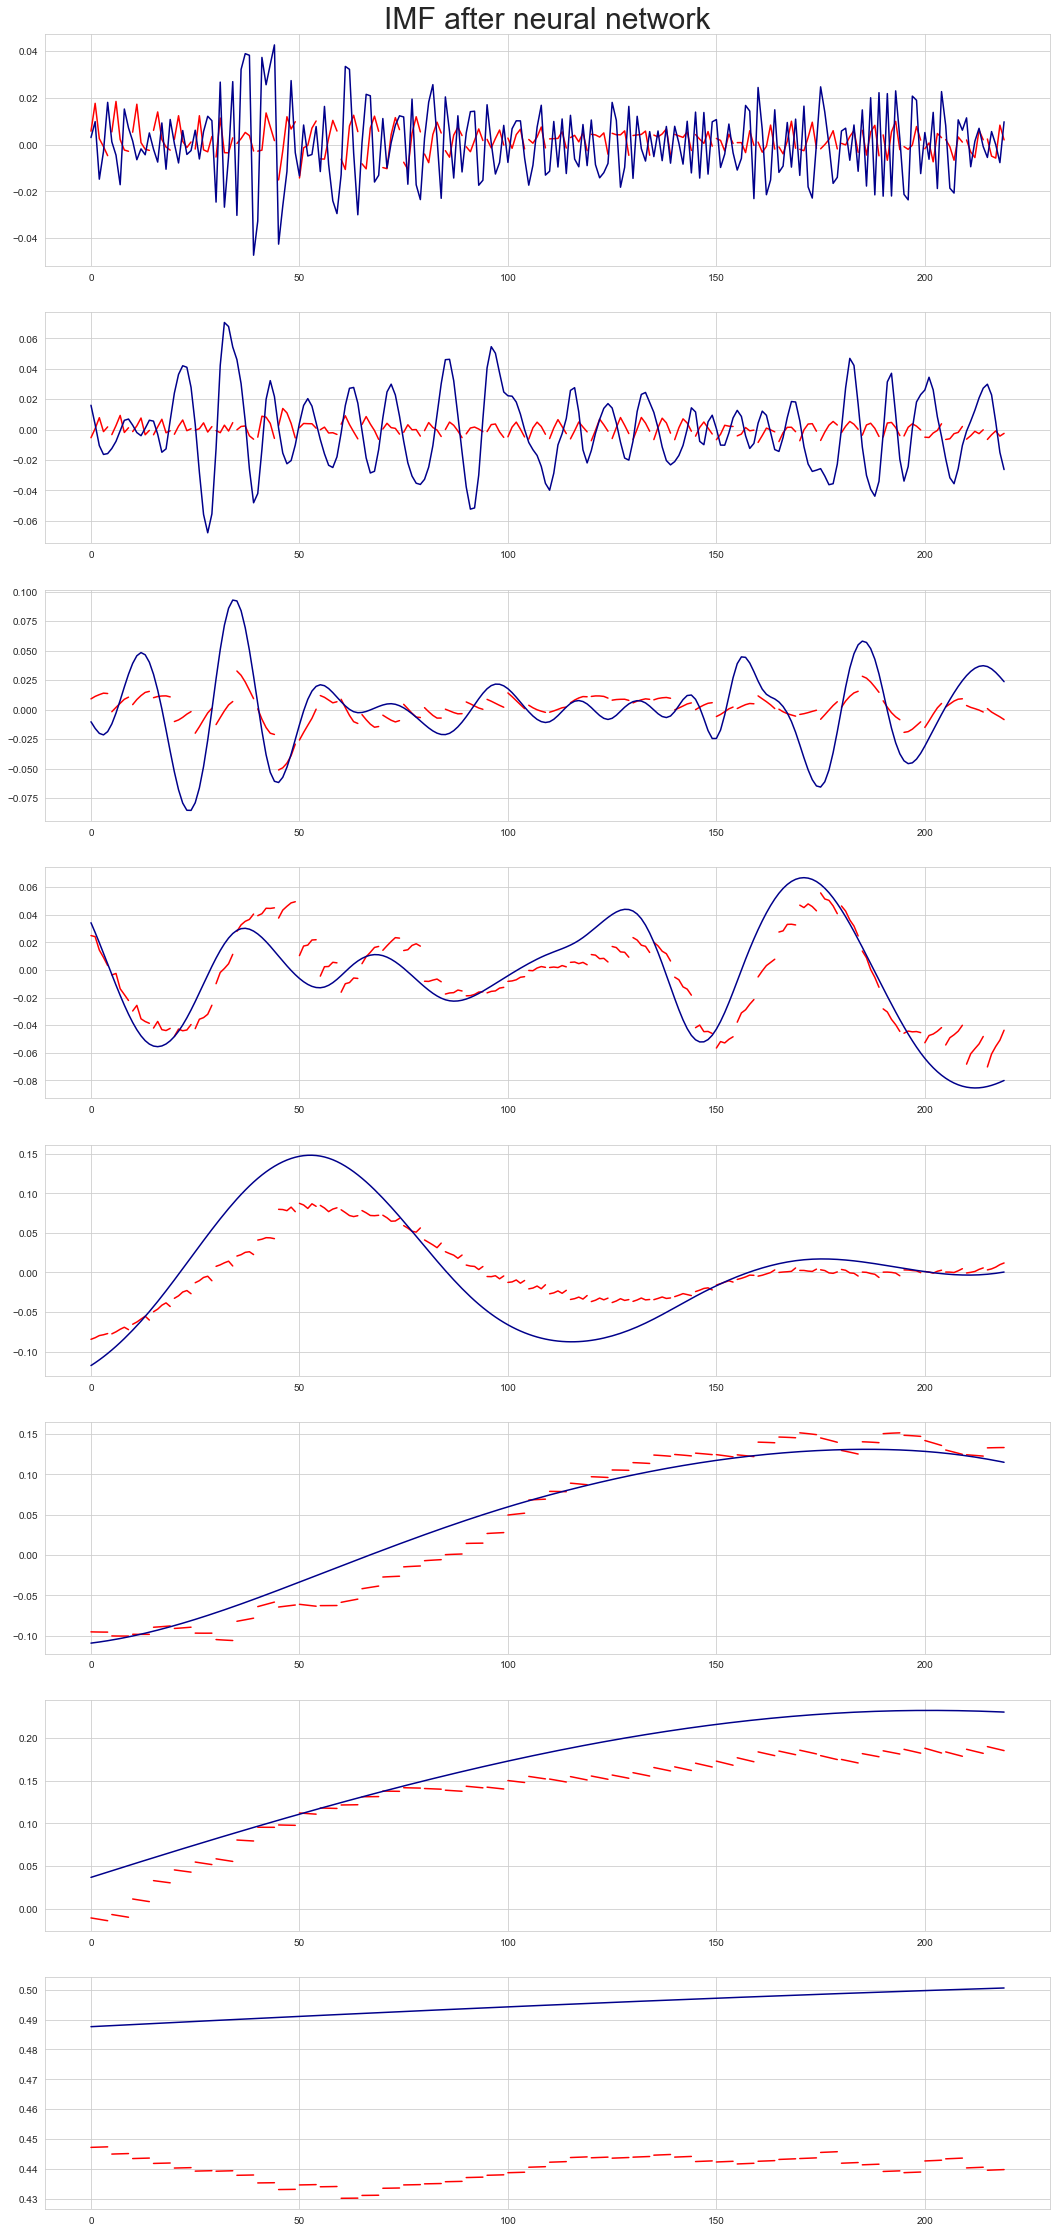

In [21]:
y_hat_test,loss_test,_,_ = sess.inference(X_test, Y_test, val=True)
y_hat_ = np.reshape(y_hat_test, (y_hat_test.shape[0], -1, dataset.shape[1]))
y_test_ = np.reshape(Y_test, (Y_test.shape[0], -1, dataset.shape[1]))

fig,ax = plt.subplots(y_hat_.shape[-1],1,figsize=(18,(y_hat_.shape[-1])*5))
ax[0].set_title("IMF after neural network", fontsize=30)
price_pred = 0
for i in range(y_hat_.shape[-1]):
    temp = y_hat_[:,:,i]
    price_pred += temp.reshape(-1,1)
    for j in range(len(temp)):
        ax[i].plot([x+j*forward_days for x in range(len(temp[j]))], temp[j].reshape(-1,1), color="red")
    ax[i].plot(y_test_[:,:,i].reshape(-1,1), color="darkblue")
price_pred = scl.inverse_transform(price_pred)
plt.show()
# plt.savefig(save_path+r"\CEEMDAN_IMF.png")

In [22]:
test_error = Tools.mse(np.ravel(test_price), np.ravel(price_pred))
test_error

9825.656650171306

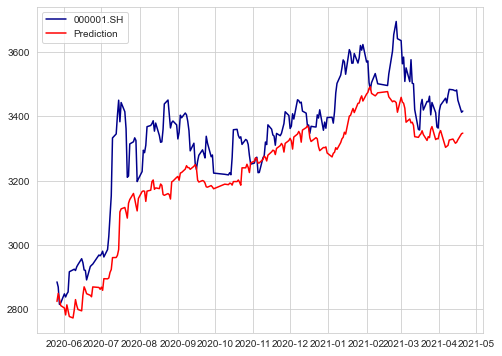

In [24]:
fig,ax = plt.subplots(figsize=(8,6))

ax.plot(pd.to_datetime(SZ_index.index)[-test_price.shape[0]:], np.ravel(test_price), color="darkblue", label="000001.SH")
ax.plot(pd.to_datetime(SZ_index.index)[-test_price.shape[0]:], np.ravel(price_pred), color="red", label="Prediction")

ax.legend()